# INF200 Lecture No 11

### 26 November 2018

## Today's topics

1. Review EX06
1. A beautiful example of parallel programming in Python
1. Creating a Graphical User Interface

    
### Note

- 3 December Lecture by Kristian Liland/Oliver Tomic on Machine Learning with Python
- **7 December 10.15-12.00** Introduction to January Project (**Tårn, T434**)
    
### Review EX06

## A beautiful example: Julia, Mandelbrot & Apfelmännchen (and a bit of parallelization)

In [1]:
import numba
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
plt.rcParams['figure.figsize'] = (8, 8)

### Introduction

Consider the function 

$$f_c(z) = z^2 + c$$ 

for complex numbers $z$ and $c$. The behavior of the number series generated by applying this function repeatedly, i.e.,

$$f_c(z_0),\: f_c(f_c(z_0)),\: f_c(f_c(f_c(z_0))),\: \dots$$

were first studied by the French mathematician [Gaston Julia](https://en.wikipedia.org/wiki/Gaston_Julia). 

The [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set) is the set of all $c\in\mathbb{C}$ for which the Julia series iterated from $z_0=0$ does not diverge, i.e., if 
$$z_{n+1} = z_n^2+c$$
fulfills
$$\left|z_n\right| \leq 2 \quad\forall n\;.$$
This set was first studied with the help of computers by the Polish-French-American mathematician [Benoit Mandelbrot](https://en.wikipedia.org/wiki/Benoit_Mandelbrot). It is a [fractal](https://en.wikipedia.org/wiki/Fractal), and due to its shape known as "Apfelmännchen" in German ("little apple man").

#### Some sample iterations

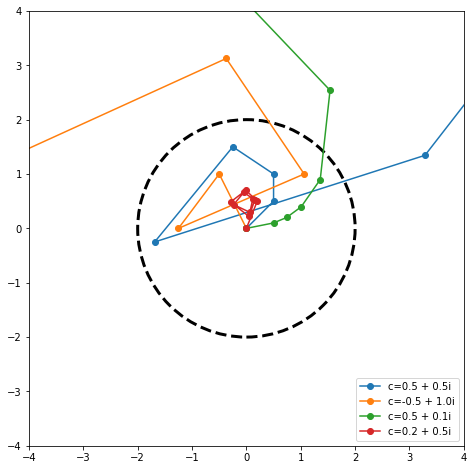

In [3]:
for c in [0.5+0.5j, -0.5+1j, 0.5+0.1j, 0.2+0.5j]:
    z = np.NaN * np.ones(10, dtype=complex)
    z[0] = 0
    for n in range(len(z)-1):
        z[n+1] = z[n]**2 + c
        if abs(z[n+1]) > 10:
            break
    plt.plot(z.real, z.imag, 'o-', label='c={} + {}i'.format(c.real, c.imag))
plt.legend(loc='lower right');
plt.xlim(-4, 4);
plt.ylim(-4, 4);
plt.gca().set_aspect('equal');
plt.gca().add_patch(plt.Circle((0, 0), radius=2, facecolor='none', edgecolor='black', lw=3, ls='--'));

### A serial Python implementation

In [4]:
def mandel_plot(x, y, m, figsize=(8, 8), cmap=cm.jet_r):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.pcolormesh(x, y, m, cmap=cmap, norm=colors.LogNorm());
    ax.set_aspect('equal');

In [5]:
@numba.jit
def mandel_iter(x, y, max_iter):
    c = complex(x, y)
    z = 0.0j
    for n in range(max_iter):
        z = z * z  + c
        if abs(z) > 2:
            return n + 1
    return max_iter

@numba.jit
def mandel_driver(xmin, xmax, ymin, ymax, width, height, max_iter=500, plot=True):
    x = np.linspace(xmin, xmax, num=width)
    y = np.linspace(ymin, ymax, num=height)
    r = np.empty((height, width))
    for i in range(height):
        for j in range(width):
            r[i, j] = mandel_iter(x[j], y[i], max_iter)
    if plot:
        mandel_plot(x, y, r)
    return r, x, y

In [6]:
mandel_driver(-2, 1, -1.5, 1.5, 500, 500, max_iter=80);

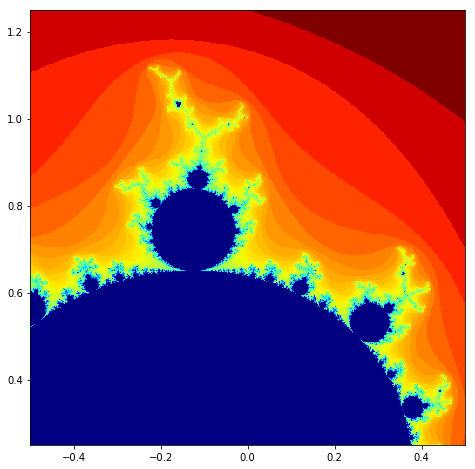

In [7]:
mandel_driver(-0.5, 0.5, 0.25, 1.25, 500, 500, max_iter=500);

- The Mandelbrot set is a *fractal* that is self-similar at all length scales

### Division of labor

- If we want to parallelize, we need to divide the computation into separate tasks
- In principle trivial here: each $c$ is independent of all other
- But: would lead to very many, very small tasks
- Need to group into larger tasks
- Simplest: one line (fixed value of $\Im(c)$) is one task
- Implement first in serial code
- Vectorize iteration function at the same time

In [8]:
@numba.vectorize
def mandel_vec_iter(x, y, max_iter=500):
    c = complex(x, y)
    z = 0.0j
    for n in range(max_iter):
        z = z * z  + c
        if abs(z) > 2:
            return n + 1
    return max_iter

@numba.jit
def mandel_line(xmin, xmax, width, y, max_iter):
    x = np.linspace(xmin, xmax, width)
    return mandel_vec_iter(x, y, max_iter)
    
@numba.jit
def mandel_line_driver(xmin, xmax, ymin, ymax, width, height, max_iter=500, plot=True):
    x = np.linspace(xmin, xmax, num=width)
    y = np.linspace(ymin, ymax, num=height)
    r = np.empty((height, width))
    for i in range(height):
        r[i, :] = mandel_line(xmin, xmax, width, y[i], max_iter)
    if plot:
        mandel_plot(x, y, r)
    return r, x, y

In [9]:
%timeit mandel_line_driver(-2, 1, -1.5, 1.5, 500, 500, max_iter=500, plot=False);

116 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


- Seems to work!

### A parallel implementation

- We use Python's [multiprocessing](https://docs.python.org/3.6/library/multiprocessing.html) module
- Runs parallel tasks in independent *processes*
- Actual parallel processing
- Tasks run as parallel *processes*: Must place code in modules and import, running directly from notebook cells does not work
- Activate [autoreloading](https://ipython.readthedocs.io/en/stable/) of modules in Notebook

In [10]:
%load_ext autoreload
%autoreload 1

In [11]:
%%writefile paramandel.py

import multiprocessing as mp
import numba
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import time

def mandel_plot(x, y, m, figsize=(12, 12), cmap=cm.jet_r):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.pcolormesh(x, y, m, cmap=cmap, norm=colors.LogNorm());
    ax.set_aspect('equal');
    
@numba.vectorize
def mandel_iter(x, y, max_iter=500):
    c = complex(x, y)
    z = 0.0j
    for n in range(max_iter):
        z = z * z  + c
        if abs(z) > 2:
            return n + 1
    return max_iter

#@numba.jit
def mandel_line(xmin, xmax, width, y, max_iter):
    x = np.linspace(xmin, xmax, width)
    return mandel_iter(x, y, max_iter)
    
#@numba.jit
def mandel_pool_driver(xmin, xmax, ymin, ymax, width, height, max_iter=500, n_proc=4, plot=True):
    x = np.linspace(xmin, xmax, num=width)
    y = np.linspace(ymin, ymax, num=height)
    with mp.Pool(processes=n_proc) as pool:
        r = np.array(pool.starmap(mandel_line,
                                 ((xmin, xmax, width, yy, max_iter) 
                                  for yy in y)))
    if plot:
        mandel_plot(x, y, r)
        
    return r, x, y

Overwriting paramandel.py


In [12]:
%aimport paramandel
from paramandel import mandel_pool_driver

In [13]:
%timeit mandel_pool_driver(-2, 1, -1.5, 1.5, 500, 500, max_iter=500, plot=False);

254 ms ± 35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


- Looks good as well!
- Should do explicit comparison of results, but we trust the figures for now

### Benchmarks

#### Initial serial version

In [14]:
%timeit -r 3 -n 1 mandel_driver(-2, 1, -1.5, 1.5, 1000, 1000, max_iter=5000, plot=False);

4.8 s ± 410 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


#### Serial version with linewise approach and vectorized iteration

In [15]:
%timeit -r 3 -n 1 mandel_line_driver(-2, 1, -1.5, 1.5, 1000, 1000, max_iter=5000, plot=False);

4.35 s ± 12.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


- Sligthly faster, presumably due to vectorized iteration

#### Parallel version, single process

In [16]:
%%timeit -r 3 -n 1 
mandel_pool_driver(-2, 1, -1.5, 1.5, 1000, 1000, 
                   max_iter=5000, plot=False, n_proc=1);

4.58 s ± 4.31 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


- Slightly slower, overhead due to process management

#### Parallel version, two processes

In [17]:
%%timeit -r 3 -n 1 
mandel_pool_driver(-2, 1, -1.5, 1.5, 1000, 1000, 
                   max_iter=5000, plot=False, n_proc=2);

2.44 s ± 52.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


- Perfect speed-up by factor 2

#### Parallel version, four processes

In [18]:
%%timeit -r 3 -n 1 
mandel_pool_driver(-2, 1, -1.5, 1.5, 1000, 1000, 
                   max_iter=5000, plot=False, n_proc=4);

1.93 s ± 46.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


- Slight gain, even though CPU has only two cores

#### Benchmark on computer with 24 cores

- Benchmark data below was obtained on a system with two Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz processors
- Each CPU has 12 hardware cores, so the system has a total of 24 hardware cores
- The CPUs support *hyperthreading*, so each physical core pretends to provide two cores
- Data are from there repetitions for $5000\times 5000$ matrices with up to $5000$ iterations

In [19]:
n_proc = [1, 2, 4, 8, 12, 24, 32, 48]
t = [245, 125, 67, 37.4, 26.7, 14.2, 13., 11.6]

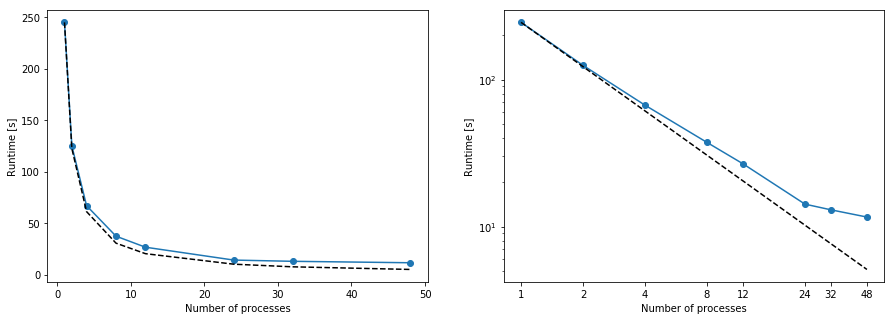

In [20]:
fig, (axn, axg) = plt.subplots(1, 2, figsize=(15, 5));
axn.plot(n_proc, t, 'o-');
axn.plot(n_proc, 245/np.array(n_proc), 'k--');
axn.set_xlabel('Number of processes');
axn.set_ylabel('Runtime [s]');

axg.loglog(n_proc, t, 'o-');
axg.loglog(n_proc, 245/np.array(n_proc), 'k--');
axg.set_xlabel('Number of processes');
axg.set_ylabel('Runtime [s]');
axg.set_xticks(n_proc);
axg.set_xticklabels(n_proc);
axg.tick_params(axis='x', which='minor', bottom=False);

- Errorbars were smaller than symbol size
- Good scaling up to 24 processes, but not perfect
- Scaling beyond 24 processes much worse
    - here we use the virtual second cores
    - do not help much for our code since code is *very* CPU intensive
- This is an example of *strong scaling*: fixed problem size, increasing number of processes

### PyCL

The following PyCL imlementation taken from https://www.ibm.com/developerworks/community/blogs/jfp/entry/How_To_Compute_Mandelbrodt_Set_Quickly?lang=en.


In [21]:
import pyopencl as cl

In [22]:
class MandelGPU:
    def __init__(self):
        self.ctx = cl.create_some_context(interactive=True)
        self.queue = cl.CommandQueue(self.ctx)

        self.prg = cl.Program(self.ctx, """
            #pragma OPENCL EXTENSION cl_khr_byte_addressable_store : enable
            __kernel void mandelbrot(__global float2 *q,
                             __global ushort *output, ushort const maxiter)
            {
                int gid = get_global_id(0);
                float nreal, real = 0;
                float imag = 0;
                output[gid] = 0;
                for(int curiter = 0; curiter < maxiter; curiter++) {
                    nreal = real*real - imag*imag + q[gid].x;
                    imag = 2* real*imag + q[gid].y;
                    real = nreal;
                    if (real*real + imag*imag > 4.0f){
                         output[gid] = curiter;
                         break;
                    }
                }
            }
            """).build()


    def _run(self, q, maxiter):
        output = np.empty(q.shape, dtype=np.uint16)

        mf = cl.mem_flags
        q_opencl = cl.Buffer(self.ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=q)
        output_opencl = cl.Buffer(self.ctx, mf.WRITE_ONLY, output.nbytes)

        self.prg.mandelbrot(self.queue, output.shape, None, q_opencl,
                            output_opencl, np.uint16(maxiter))

        cl.enqueue_copy(self.queue, output, output_opencl).wait()
    
        return output
    
    def run(self, xmin, xmax, ymin, ymax, width, height, max_iter=500, plot=True):
        x = np.linspace(xmin, xmax, num=width, dtype=np.float32)
        y = np.linspace(ymin, ymax, num=height, dtype=np.float32)
        c = x + y[:,None]*1j
        c = np.ravel(c)
        n = self._run(c, max_iter)
        n = n.reshape((width, height))
                
        if plot:
            mandel_plot(x, y, n)
        return n, x, y

In [23]:
mg = MandelGPU()

Choose platform:
[0] <pyopencl.Platform 'Apple' at 0x7fff0000>


Choice [0]: 0


Choose device(s):
[0] <pyopencl.Device 'Intel(R) Core(TM) i5-5287U CPU @ 2.90GHz' on 'Apple' at 0xffffffff>
[1] <pyopencl.Device 'Intel(R) Iris(TM) Graphics 6100' on 'Apple' at 0x1024500>


Choice, comma-separated [0]: 1


Set the environment variable PYOPENCL_CTX='0:1' to avoid being asked again.


In [25]:
%timeit mg.run(-2, 1, -1.5, 1.5, 1000, 1000, 5000, plot=False);

50.6 ms ± 302 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


- About 40 times faster than with four processors on CPU
- But: Uses only 32-bit floats, not 64 bit as CPU, so lower resolution

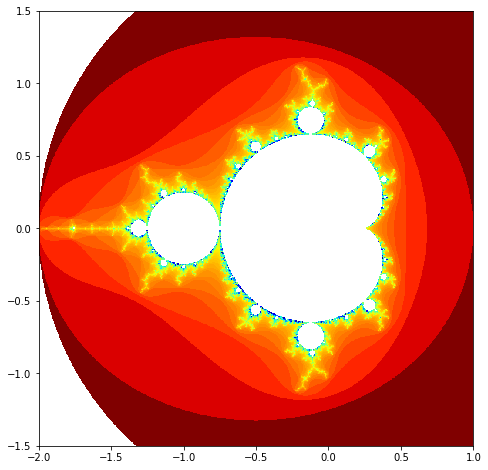

In [26]:
mg.run(-2, 1, -1.5, 1.5, 1000, 1000, 5000, plot=True);

## Creating a GUI

- Software can be easier to use with a graphical user interface (GUI)
- Many different GUI toolkits available
- Some examples
    - [TkInter](https://wiki.python.org/moin/TkInter) based on [Tcl/Tk](https://en.wikipedia.org/wiki/Tk_(software))
    - [PyQt](https://www.riverbankcomputing.com/software/pyqt/intro) (pronouced "py-cute") and [PySide2](https://www.qt.io/qt-for-python) based on [Qt](https://www.qt.io)
    - [Kivy](kivy.org)
    - [Dash](https://plot.ly/products/dash/) based on [Plotly](https://plot.ly)
- Serving applications via the web
    - Frequently, today, GUIs run in a web browser, interacting with a backend running on a remote server (e.g. GoogleDocs)
    - One can also run a a server locally (as with Jupyter notebooks)
    - A popular Python package for this purpose is [Flask](http://flask.pocoo.org)
    - [JSON](https://en.wikipedia.org/wiki/JSON) (JavaScript Object Notation) is commonly used to transfer information between server and client
    - Client software commonly written in [JavaScript](https://en.wikipedia.org/wiki/JavaScript)
        - Allows considerable "intelligence" on the client side
    - Many frameworks support development, e.g.
        - [AngularJS](https://angular.io) (from Google)
        - [ReactJS](https://reactjs.org) (from Facebook)
        - [three.js](https://threejs.org) (for 3D graphics)
        - [Django](https://www.djangoproject.com) (Python-based)

### Model-View-Controller Pattern

<img src="figures/MVC-Process.svg" width=30%> 
(By RegisFrey - Own work, Public Domain, https://commons.wikimedia.org/w/index.php?curid=10298177)

- *Model* is data and operations of underlying application, e.g., a simulation
- *View* presents model to user, different views are possible
- *Controller* allows user to modify model
- View and Controller form the user interface
- Clean separation of model from interface important for flexibility and maintainability

### Example: NEST Instrumentation App

- Permits users to connect stimulation and recording devices to a neuronal network
- Developed by Stine Vennemo and Håkon Mørk for the Human Brain Project

<img src="figures/3D_poisson_connected.png" width=80%>

#### Implementation

<img src="figures/NEST_App_Implementation.png" width=80%>

## Practical examples

- We will implement simple GUIs using Matplotlib GUI support

### Key elements

- **Figure** holds a Matplotlib GUI
- **Canvas** is essentially the "paper" the figure is drawn on
- **Axes** are boxes that can hold graphical elements, e.g., plots, text, or widgets
- **Wigdets** are elements of a GUI, e.g., buttons, sliders, selection tools
- **Events** are triggered when the user clicks or moves the mouse, or types
- **Callback** functions are called when events occur
- **Infinite loop** runs until application terminates
    - events trigger callbacks
    - callbacks do things
    
### Examples
- `gui_examples/demo_gui.py`
- `gui_examples/mandel_gui_with_doc.py`

### Documentation

- https://matplotlib.org/gallery/widgets/slider_demo.html
- https://matplotlib.org/users/event_handling.html
- https://matplotlib.org/api/widgets_api.html
- https://matplotlib.org/examples/widgets/buttons.html